# Timeseries analysis

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import warnings

warnings.filterwarnings('ignore')

import statsmodels.api as sm
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
plt.rcParams['figure.figsize'] = (8,4)

In [3]:
merged = pd.read_csv('data/outputs/merged.csv', parse_dates=['datetime'], index_col=0)
demo_list = list(pd.read_csv('data/hh_demographic.csv')['household_key'])
merged_demo = merged[merged['household_key'].isin(demo_list)]
merged_demo.to_csv('data/outputs/merged_demo.csv')

In [4]:
merged_demo = pd.read_csv('data/outputs/merged_demo.csv')

In [5]:
merged_demo.shape

(1320234, 21)

# Plotting Sales

<AxesSubplot:xlabel='datetime'>

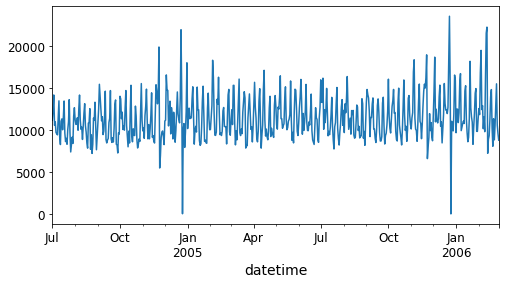

In [6]:
sales_series = merged.resample('D', on='datetime')['SALES_VALUE'].sum()
sales_series.plot()

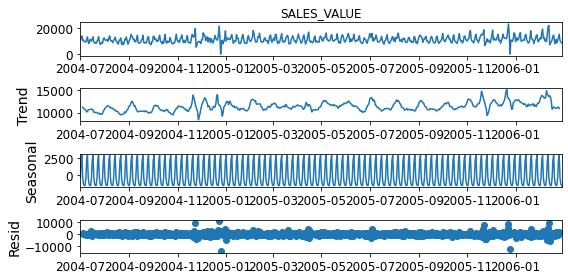

In [7]:
decomposition = sm.tsa.seasonal_decompose(sales_series) #
decomposition.plot()
plt.show()

Above, we can see the seasonality of the timeseries; it's trend; and the residuals (or errors). We notice that the christmas/thanksgiving are still anomalous and recognizable, outside of the normal seasonal pattern. We used a daily pattern, and they are anomalous sales days. These longer-term patterns might be referred to as cycles. I'm fascinated with the fast fourier transform, and hope to learn more about it. 

In [8]:
len(sales_series) == decomposition.nobs[0]
# the number of observations is given by .nobs

True

In [9]:
# decomposition.resid
# # the variance NOT explained by seasonality or trend os available as .resid

# decomposition.seasonal.plot()

# decomposition.trend.plot()
# # the trend and seasonality are available as well.

# #Collectively, they return the original timeseries;

# (decomposition.trend + decomposition.seasonal + decomposition.resid).plot()
# sales_series.plot(color='orange', alpha=0.4)

# ACF and PACF

The auto-correlation and partial autocorrelation functions (ACF and PACF) are effectively calculated by performing a .shift() for each of a set number of 'lag' periods in the timeseries, and then calculating the correlation between the current value and the shifted value.

For a timeseries where the x-axis is measured in days, this means that each lag period will be equivalent to one day. The shaded area surrounding the x-axis on the plot (the lag periods) reflects the p-value boundary (0.05) of the correlation; therefore, where the lag value is outside of the shaded area, there is a statistically significant effect. 

Time series "stationarity" is a requirement for this form of analysis; and reflects one of the basic tenets of timeseries: that each successive value will have it's state at least partially derived from the previous state. 

**From the basis of lag 0, where correlation is 1, are there any discernible patterns in the correlation plot, and what might that suggest about our underlying data?**

note: PACF reflects the idea that there is a natural disintegration of correlative effects as a timeseries passes forwards. The correlative impact of longer lag times are neutralized somewhat, which in turn allows for better definition of longterm effects when they are significant; there is less 'noise' from repetitive pattern of lower-lag seasonality, without having to filter them out from your analysis directly.

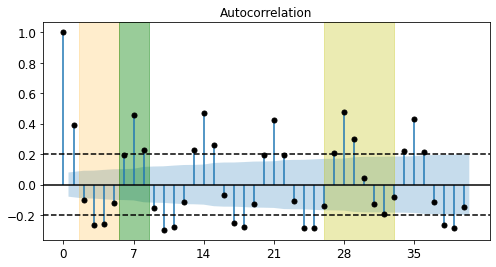

In [10]:
sm.tsa.graphics.plot_acf(sales_series, lags=40, color='black')
plt.axhline(0.2, ls='--', color='black')
plt.axhline(-0.2, ls='--', color='black')


plt.axvspan(1.5,5.5, color='orange', alpha=0.2)
plt.axvspan(5.5,8.5, color='green', alpha=0.4)
plt.axvspan(26,33, color='y', alpha=0.3)
plt.xticks(range(0, 41, 7))
plt.show()
# we can see the correlation between sales on a given day (0), and sales for days with a given 'lag'; 
# there appears to be a repeating pattern (weekly seasonality)

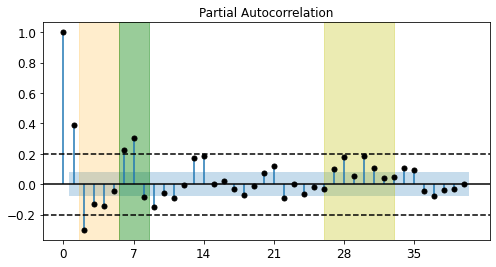

In [11]:
fig = sm.tsa.graphics.plot_pacf(sales_series, lags=40, color='black')
# in this partial auto-correlation plot we diminish the correlation value, the further we get from day 0. 
plt.axhline(0.2, ls='--', color='black')
plt.axhline(-0.2, ls='--', color='black')


plt.axvspan(1.5,5.5, color='orange', alpha=0.2)
plt.axvspan(5.5,8.5, color='green', alpha=0.4)
plt.axvspan(26,33, color='y', alpha=0.3)
plt.xticks(range(0, 41, 7))
plt.show()
# Note that these are the same lag periods. 

C:\Users\polan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


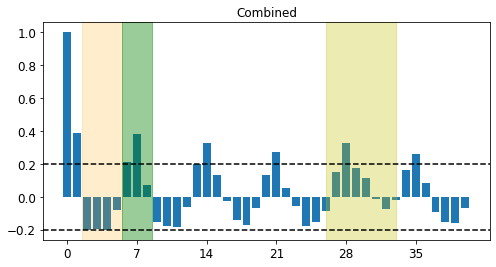

In [12]:
# take the mean?
plt.bar(range(0,41), (sm.tsa.pacf(sales_series, nlags=40) + sm.tsa.acf(sales_series, nlags=40))/2) # divide in half
plt.title('Combined')
plt.axhline(0.2, ls='--', color='black')
plt.axhline(-0.2, ls='--', color='black')


plt.axvspan(1.5,5.5, color='orange', alpha=0.2)
plt.axvspan(5.5,8.5, color='green', alpha=0.4)
plt.axvspan(26,33, color='y', alpha=0.3)
plt.xticks(range(0, 41, 7))
plt.show()
plt.show()

Above, we can see what looks like a 7 day seasonal pattern in effect.  Moreover, there is some form of 'monthly' correlation; days 27-33 are seemingly atypical.

Interesting to note is the negative 2-day-lag partial autocorrelation -- and the equivalent 3-4 negative correlation.  
The 2-day negative correlation is independent of the weeklday seasonal pattern, and I would argue that it is therefore a fairly interesting and fast-repeating indicator in this timeseries that may reflect customer behaviour overall.

Since we have not pieced the sales for each household apart; it could be the case that some households are 6-7 day shoppers, where others are 14 day or even 28 day shoppers, and that the sales signals from different households are becoming inter-mingled. 

**There is a 6-7-8 day seasonal effect from the days of the week, and what appears to be a negative 2-3-4 day negative correlation where households generally won't purchase again.**

# SARIMAX Model

## Optimizing order and seasonal order

Below we optimize for p,d,q orders for our SARIMAX model.

source: [https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)

In [27]:
def test_SARIMAX(sales_series, seasonal_window=7):
    
    
    # set pdq order range
    p = d = q = range(0, 2) 
    
    # make combos
    pdq = list(itertools.product(p, d, q))
    
    ### seasonal PDQM values
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_window) for x in list(itertools.product(p, d, q))]

    # container for lowest AIC score
    lowest = (0, 0, 999999999999)

    # iterate through pdq values up to order 2
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            
            #
            model = sm.tsa.statespace.SARIMAX(sales_series,
                                                order=param,
                                                seasonal_order=param_seasonal)
            results = model.fit()
    #         print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < lowest[2]:
                print(f'SARIMA{param}x{param_seasonal} - AIC:{results.aic} -- lowest:{lowest}')

                lowest = (param, param_seasonal, results.aic)
    #         except:
    #             continue

    return lowest

test_SARIMAX(sales_series)

SARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:13116.259936544377 -- lowest:(0, 0, 999999999999)
SARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:12537.462807318232 -- lowest:((0, 0, 0), (0, 0, 0, 7), 13116.259936544377)
SARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:11203.788581279496 -- lowest:((0, 0, 0), (0, 0, 1, 7), 12537.462807318232)
SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:10893.92580646852 -- lowest:((0, 0, 0), (0, 1, 0, 7), 11203.788581279496)
SARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:10825.66623694721 -- lowest:((0, 0, 0), (0, 1, 1, 7), 10893.92580646852)
SARIMA(1, 0, 0)x(0, 1, 1, 7) - AIC:10825.483862734916 -- lowest:((0, 0, 1), (0, 1, 1, 7), 10825.66623694721)
SARIMA(1, 1, 1)x(0, 1, 1, 7) - AIC:10792.123113250658 -- lowest:((1, 0, 0), (0, 1, 1, 7), 10825.483862734916)
SARIMA(1, 1, 1)x(1, 0, 1, 7) - AIC:1001.8978980118806 -- lowest:((1, 1, 1), (0, 1, 1, 7), 10792.123113250658)


((1, 1, 1), (1, 0, 1, 7), 1001.8978980118806)

## Train Test Split

In [18]:
train = sales_series[:-40]
test = sales_series[-40:]
# timeseries data must be split cleanly, not sampled at random

In [19]:
# instantiate
model = sm.tsa.statespace.SARIMAX(train,
                          order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7),) # use the optimized parameters

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3025      0.022     13.642      0.000       0.259       0.346
ma.L1         -1.0000      0.022    -45.795      0.000      -1.043      -0.957
ar.S.L7        0.0359      0.041      0.874      0.382      -0.045       0.116
ma.S.L7       -0.9452      0.025    -37.952      0.000      -0.994      -0.896
sigma2      3.292e+06   6.63e-09   4.96e+14      0.000    3.29e+06    3.29e+06


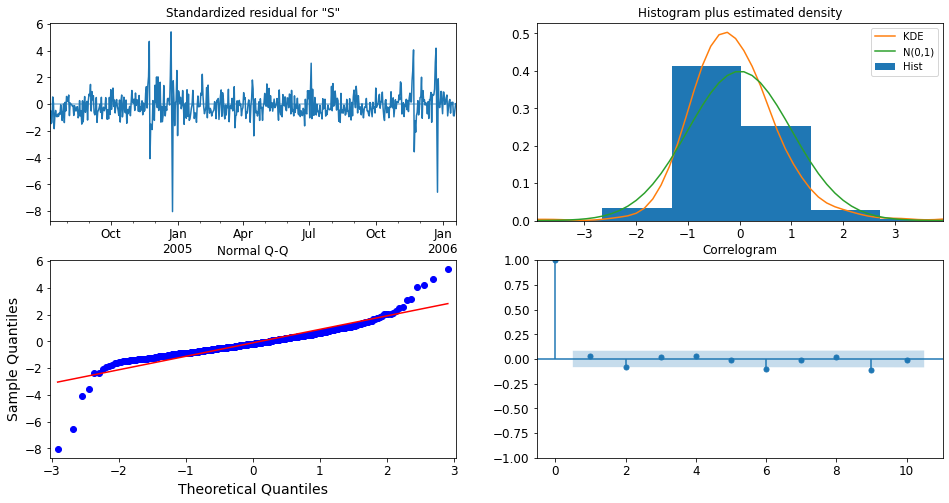

In [28]:
# fit
results = model.fit()
# score
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

We've trained this state-space model on the beginning of our timeseries, hoping to predict the values near the end. By optimizing the seasonality/lag parameters (above), we can extract the seasonal effects from our predictions.

## Making Predictions

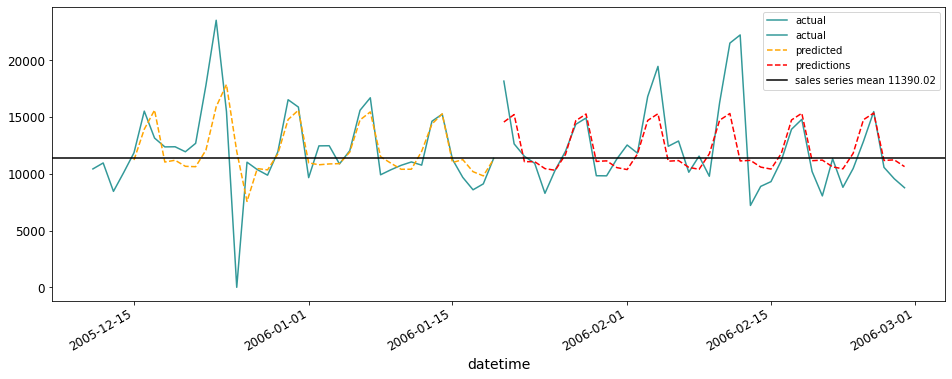

In [29]:
plt.figure(figsize=(16,6))
plt.plot(test, label='actual', color='teal', alpha=0.8)
plt.plot(train[-40:], label='actual', color='teal', alpha=0.8)
# the next 40 predicted values
# the generated model (space predictions)
results.predict(-40)[4:].plot(ls='--', label='predicted', color='orange')
plt.plot(results.forecast(40), ls='--', label='predictions', color='red')
plt.axhline(sales_series.mean(), label=f'sales series mean {round(sales_series.mean(),2)}', color='black')
plt.legend()

In the above plot, we can see Christmas 2005, as well as the storm of February 2006 reflected in our data. Looks pretty good! What's our level of error?

In [36]:
results.mae 

1319.9712897074214

In [135]:
(results.mae/11390) *100 ## 11390 is the mean of the series

11.588861191461119

In [140]:
np.std(sales_series)

2596.0308515206857

# Conclusions

This model has a mean average error of 11.5% of the total sales value (per day?), which poses significant monetary risk. 

However, this \$1300 is only about half of one standard deviation from the sales_series mean (of the data we have...), which is pretty impressive, all things considered. 